# Adaptive/Predictive MinMax Homework
## Alessandro Pio 294417
## Lorenzo Tucceri Cimini 294425

In [1]:
!pip install python-chess
!pip install tqdm
!pip install matplotlib

In [2]:
import numpy as np
import tensorflow as tf
import chess
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pandas as pd
import seaborn as sns

## Check if GPU is avaiable

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU trovata: {physical_devices}")
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(f"Errore nella configurazione della memoria GPU: {e}")
else:
    print("Nessuna GPU trovata. Assicurati di avere i driver CUDA installati.")

GPU trovata: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Chess Evaluation with MinMax and Neural Networks: Theoretical Summary

This notebook provides an overview of the theoretical framework implemented in the provided code, which combines machine learning and traditional search algorithms for chess evaluation.

---

## **Key Concepts**

1. **Regressor RL1:**
   - A neural network trained to predict the evaluation function \( HL1 \) calculated using the MinMax algorithm at a fixed depth \( L1 \).
   - Once trained, \( RL1 \) replaces static evaluation \( H0 \), allowing more efficient simulations of deeper MinMax searches.

2. **Algorithms:**
   - **abMinMaxL:** Traditional Alpha-Beta pruning MinMax algorithm exploring the game tree up to depth \( L \).
   - **abRL1MinMaxL:** A modified version of \( abMinMaxL \) that uses \( RL1 \) instead of \( H0 \), simulating \( abMinMax(L + L1) \).
   - **bRlMinMaxL:** A branch-limited MinMax algorithm, where \( RL1 \) is used to approximate \( HL \), reducing the exploration overhead.

3. **Iterative Bootstrapping:**
   - Begins by training \( RL1 \) at a small depth \( L1 \).
   - Uses \( RL1 \) to simulate deeper evaluations \( abMinMax(L + L1) \).
   - Generates datasets at progressively deeper depths (e.g., \( L, 2L, 4L, \dots \)).
   - Trains new regressors \( RL2, RL4, \dots \) without directly performing full tree exploration.

---

## **Theoretical Steps**

### Step 1: Training the First Regressor \( RL1 \)
- Generate a dataset of chess positions.
- Evaluate each position using \( abMinMaxL1 \) to compute \( HL1 \).
- Train \( RL1 \) to predict \( HL1 \) given the position features.

### Step 2: Using \( RL1 \) in MinMax
- Replace \( H0 \) in \( abMinMaxL \) with predictions from \( RL1 \).
- This modified algorithm (\( abRL1MinMaxL \)) simulates \( abMinMax(L + L1) \).

### Step 3: Branch-Limited Exploration
- Introduce \( bRlMinMaxL \), where \( RL1 \) approximates \( HL \) for limiting branching.
- Allows efficient simulations at depth \( L \) with branch-limited exploration.

### Step 4: Iterative Bootstrapping
- Generate training data at depth \( L \) using \( abMinMaxL \).
- Train a new regressor \( RL \) to simulate deeper searches.
- Use the new regressor to train subsequent regressors at greater depths (\( 2L, 4L, \dots \)).

---

## **Advantages of the Framework**

1. **Efficiency:**
   - Reduces the computational cost of deep searches by replacing tree exploration with regressor predictions.

2. **Scalability:**
   - Enables simulations at greater depths without direct exploration.

3. **Theoretical Equivalence:**
   - Algorithms like \( bRL1\_RL1MinMaxL1 \) simulate deeper searches (e.g., \( abMinMax(2L1) \)) while maintaining reasonable computational requirements.

---

## **Implementation Highlights**

1. **Feature Extraction:**
   - Chess positions are encoded as numerical feature vectors, including:
     - Turn, castling rights, material evaluation, center control, etc.

2. **Neural Network Design:**
   - Fully connected feedforward network with two hidden layers and ReLU activation.

3. **Evaluation Metrics:**
   - Mean Absolute Error (MAE) is used to monitor regressor performance during training.

4. **Visualization:**
   - Dataset sizes, training times, and error metrics are plotted to analyze the bootstrapping process.



In [4]:
class RegressorRL:
    def __init__(self, input_dim=15, hidden_units=128):
        """Builds the RL1 regressor to simulate HL1"""
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_units, activation='relu', input_dim=input_dim),
            tf.keras.layers.Dense(hidden_units, activation='relu'),
            tf.keras.layers.Dense(1)  # out
        ])
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def train(self, X, y, epochs=150, batch_size=32):
        """Train the regressor RL1"""
        with tf.device('/GPU:0'):  # use gpu for traing
            history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
        return history

    def predict(self, state_features):
        """Predicts the value of HL1 given a state (features)"""
        with tf.device('/GPU:0'):  # Usa la GPU per la predizione
            return self.model.predict(state_features)


def extract_features(board):
    """
    Transforms a board state into a numerical vector based on derived features.
    This representation excludes direct encoding of the board.
    Included features:
    - Player's turn.
    - Castling rights.
    - Fifty-move rule.
    - En passant status.
    - Total number of pieces per color.
    - Material evaluation.
    - Control of the center.
    - Number of legal moves.
    - check or checkmate.
    """

    turn = 1 if board.turn else 0

    castling_rights = [
        int(board.has_kingside_castling_rights(chess.WHITE)),
        int(board.has_queenside_castling_rights(chess.WHITE)),
        int(board.has_kingside_castling_rights(chess.BLACK)),
        int(board.has_queenside_castling_rights(chess.BLACK)),
    ]

    halfmove_clock = board.halfmove_clock
    en_passant = board.ep_square if board.ep_square else -1
    white_pieces = sum(1 for piece in board.piece_map().values() if piece.color == chess.WHITE)
    black_pieces = sum(1 for piece in board.piece_map().values() if piece.color == chess.BLACK)
    piece_values = {
        chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
        chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0
    }
    material_score = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            value = piece_values[piece.piece_type]
            material_score += value if piece.color == chess.WHITE else -value

    center_squares = [chess.D4, chess.D5, chess.E4, chess.E5]
    white_center_control = sum(1 for sq in center_squares if board.is_attacked_by(chess.WHITE, sq))
    black_center_control = sum(1 for sq in center_squares if board.is_attacked_by(chess.BLACK, sq))

    legal_moves_count = board.legal_moves.count()

    is_check = int(board.is_check())          # 1 se è scacco, 0 altrimenti
    is_checkmate = int(board.is_checkmate())  # 1 se è scacco matto, 0 altrimenti

    features = np.array([
        turn,                       # turno (1 elemento)
        *castling_rights,           # arrocco (4 elementi)
        halfmove_clock,             # regola delle cinquanta mosse (1 elemento)
        en_passant,                 # stato di en passant (1 elemento)
        white_pieces,               # numero totale di pezzi bianchi (1 elemento)
        black_pieces,               # numero totale di pezzi neri (1 elemento)
        material_score,             # valutazione del materiale (1 elemento)
        white_center_control,       # controllo del centro bianco (1 elemento)
        black_center_control,       # controllo del centro nero (1 elemento)
        legal_moves_count,          # numero di mosse legali (1 elemento)
        is_check,                   # stato di scacco (1 elemento)
        is_checkmate                # stato di scacco matto (1 elemento)
    ])

    return features

def abRL1MinMaxL(board, depth, is_maximizing, rl1_regressor):
    """abMinMax con regressor RL1 invece di H0"""
    with tf.device('/GPU:0'):
        if depth == 0 or board.is_game_over():
            features = extract_features(board)
            return rl1_regressor.predict(features.reshape(1, -1))[0]

        if is_maximizing:
            max_eval = -np.inf
            for move in board.legal_moves:
                board.push(move)
                eval = abRL1MinMaxL(board, depth - 1, False, rl1_regressor)
                max_eval = max(max_eval, eval)
                board.pop()
            return max_eval
        else:
            min_eval = np.inf
            for move in board.legal_moves:
                board.push(move)
                eval = abRL1MinMaxL(board, depth - 1, True, rl1_regressor)
                min_eval = min(min_eval, eval)
                board.pop()
            return min_eval

def bRlMinMaxL(board, depth, rl1_regressor):
    """Branch-limited MinMax with regressor RL1"""
    best_move = None
    best_value = -np.inf if board.turn else np.inf
    with tf.device('/GPU:0'):
        for move in board.legal_moves:
            board.push(move)
            value = abRL1MinMaxL(board, depth - 1, not board.turn, rl1_regressor)
            board.pop()

            if board.turn:
                if value > best_value:
                    best_value = value
                    best_move = move
            else:
                if value < best_value:
                    best_value = value
                    best_move = move

    return best_move, best_value


def evaluate_board_different(features):
    """
    Evaluates the board state to determine a score based on extracted features.

    Args:
        features (np.array): A numerical vector representing the board features.

    Returns:
        float: A numerical value representing the strength of the position.
    """

    weights = np.array([
        1.0,   # Turno
        0.5,   # Arrocco bianco (kingside)
        0.5,   # Arrocco bianco (queenside)
        0.5,   # Arrocco nero (kingside)
        0.5,   # Arrocco nero (queenside)
        -0.1,  # Regola delle cinquanta mosse
        0.2,   # Stato di en passant 0.1
        0.3,   # Numero totale di pezzi bianchi
        -0.3,  # Numero totale di pezzi neri
        0.1,   # Valutazione del materiale
        0.4,   # Controllo del centro bianco
        -0.4,  # Controllo del centro nero
        0.2,   # Numero di mosse legali
        1.5,   # Stato di scacco
        -1.5   # Stato di scacco matto
    ])

    score = np.dot(features, weights)

    return score


def abMinMaxL(board, depth, alpha=-np.inf, beta=np.inf, is_maximizing=True):
    """
    Implementation of the Alpha-Beta pruning algorithm (abMinMax) for chess.

    Args:
        board (chess.Board): The current state of the board.
        depth (int): Maximum exploration depth.
        alpha (float): Alpha value for pruning.
        beta (float): Beta value for pruning.
        is_maximizing (bool): True if it is the maximizer's turn, False for the minimizer.

    Returns:
        float: Evaluation of the position.
    """
    with tf.device('/GPU:0'):
        if depth == 0 or board.is_game_over():
            feat = extract_features(board)
            return evaluate_board_different(feat)

        if is_maximizing:
            max_eval = -np.inf
            for move in board.legal_moves:
                board.push(move)
                eval = abMinMaxL(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break  # Beta cutoff
            return max_eval
        else:
            min_eval = np.inf
            for move in board.legal_moves:
                board.push(move)
                eval = abMinMaxL(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

def generate_dataset(board_states, minmax_algo, depth=1):
    """Generates a dataset of states and evaluations with abMinMax(L1)."""
    X, y = [], []
    start_time = time.time()
    with tf.device('/GPU:0'):

        for board in tqdm(board_states, desc='Generating dataset'):
            features = extract_features(board)
            hl1_value = minmax_algo(board, depth)
            X.append(features)
            y.append(hl1_value)
    end_time = time.time()
    print(f"Dataset generato in {end_time - start_time:.2f} secondi.")
    return np.array(X), np.array(y), end_time - start_time


def iterative_bootstrap(board_states, initial_depth=1, max_depth=8, depth_minmax=4, dataset="initial_dataset.pkl"):
    """Iterative: trains RL regressors to simulate deeper explorations."""
    depth = initial_depth
    models = []
    dataset_sizes = []
    training_times = []
    mae_values = []
    generation_times = []

    rl_regressor = None  # Il regressore per simulare le profondità

    while depth <= max_depth:
        print(f"Generazione dataset per profondità {depth}")

        if rl_regressor is None:
            X, y, gen_time = generate_dataset(board_states, lambda b, d: abMinMaxL(b, d), depth_minmax)
        else:
            print(f"Simulazione dataset con il regressore RL per profondità {depth}")
            start_time = time.time()
            simulated_dataset = simulate_dataset_with_regressor(rl_regressor, board_states)
            X, y = zip(*simulated_dataset)
            X = np.array(X) # Convert X to a NumPy array
            y = np.array(y) # Convert y to a NumPy array
            gen_time = time.time() - start_time

        dataset_sizes.append(len(X))
        generation_times.append(gen_time)

        print(f"Allenamento regressore RL per profondità {depth}")
        rl_regressor = RegressorRL(input_dim=X[0].shape[0])
        start_time = time.time()
        history = rl_regressor.train(X, y)
        end_time = time.time()
        training_times.append(end_time - start_time)

        mae = history.history['mae'][-1]
        mae_values.append(mae)

        print(f"Profondità {depth} completata: MAE={mae:.4f}, Tempo di training={end_time - start_time:.2f}s")
        models.append(rl_regressor)

        depth *= 2

    plot_statistics(dataset_sizes, training_times, generation_times, mae_values, initial_depth, max_depth)

    return models

def plot_statistics(dataset_sizes, training_times, generation_times, mae_values, initial_depth, max_depth):
    depths = [initial_depth * (2 ** i) for i in range(len(dataset_sizes))]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(depths, dataset_sizes, marker='o')
    plt.title("Dimensione del dataset a ogni profondità")
    plt.xlabel("Profondità")
    plt.ylabel("Dimensione del dataset")

    plt.subplot(2, 2, 2)
    plt.plot(depths, generation_times, marker='o', color='orange')
    plt.title("Tempo di generazione del dataset")
    plt.xlabel("Profondità")
    plt.ylabel("Tempo (s)")

    plt.subplot(2, 2, 3)
    plt.plot(depths, training_times, marker='o', color='green')
    plt.title("Tempo di training del modello")
    plt.xlabel("Profondità")
    plt.ylabel("Tempo (s)")

    plt.subplot(2, 2, 4)
    plt.plot(depths, mae_values, marker='o', color='red')
    plt.title("Errore MAE sul dataset di training")
    plt.xlabel("Profondità")
    plt.ylabel("MAE")

    plt.tight_layout()
    plt.show()

def generate_random_board_states(n):
    """Generates n random board states."""
    states = []
    for _ in range(n):
        board = chess.Board()
        for _ in range(np.random.randint(1, 20)):
            if board.is_game_over():
                break
            move = np.random.choice(list(board.legal_moves))
            board.push(move)
        states.append(board)
    return states

def get_trained_models(num_boards=100, initial_L=1, max_L=8, depth_minmax=4, dataset="initial_dataset.pkl"):
    """
    Generates chess states and trains RL regressors at multiple depths.
    Returns a list of trained models.
    """
    print("Generazione degli stati iniziali della scacchiera...")
    board_states = generate_random_board_states(num_boards)

    print("Inizio bootstrap iterativo...")
    return iterative_bootstrap(board_states, initial_depth=initial_L, max_depth=max_L, depth_minmax=depth_minmax, dataset=dataset)

In [5]:
def simulate_dataset_with_regressor(rl_regressor, board_states):
    """
    Simula un dataset per una profondità usando un regressore già allenato.
    """
    dataset = []

    for _, board in enumerate(board_states):
        features = extract_features(board)

        predicted_value = rl_regressor.predict(features.reshape(1, -1))[0][0]  # Regressore predice HL, prendi il valore scalare
        dataset.append((features, predicted_value))

    return dataset

Generazione degli stati iniziali della scacchiera...
Inizio bootstrap iterativo...
Generazione dataset per profondità 1


Generating dataset: 100%|██████████| 1000/1000 [55:30<00:00,  3.33s/it] 

Dataset generato in 3330.91 secondi.
Allenamento regressore RL per profondità 1
Epoch 1/150


32/32 [==============================] - 2s 3ms/step - loss: 8.6664 - mae: 2.2406
Epoch 2/150
32/32 [==============================] - 0s 3ms/step - loss: 2.4283 - mae: 1.2361
Epoch 3/150
32/32 [==============================] - 0s 3ms/step - loss: 2.1978 - mae: 1.1698
Epoch 4/150
32/32 [==============================] - 0s 2ms/step - loss: 2.0164 - mae: 1.1367
Epoch 5/150
32/32 [==============================] - 0s 2ms/step - loss: 1.9644 - mae: 1.1073
Epoch 6/150
32/32 [==============================] - 0s 2ms/step - loss: 1.8433 - mae: 1.0852
Epoch 7/150
32/32 [==============================] - 0s 2ms/step - loss: 1.9866 - mae: 1.1178
Epoch 8/150
32/32 [==============================] - 0s 2ms/step - loss: 1.8298 - mae: 1.0768
Epoch 9/150
32/32 [==============================] - 0s 1ms/step - loss: 1.7470 - mae: 1.0369
Epoch 10/150
32/32 [==============================] - 0s 1ms/step - loss: 1.6912 - mae: 1.0276
Epoch 11/150
32/32 [==============================] - 0s 1ms/step - los

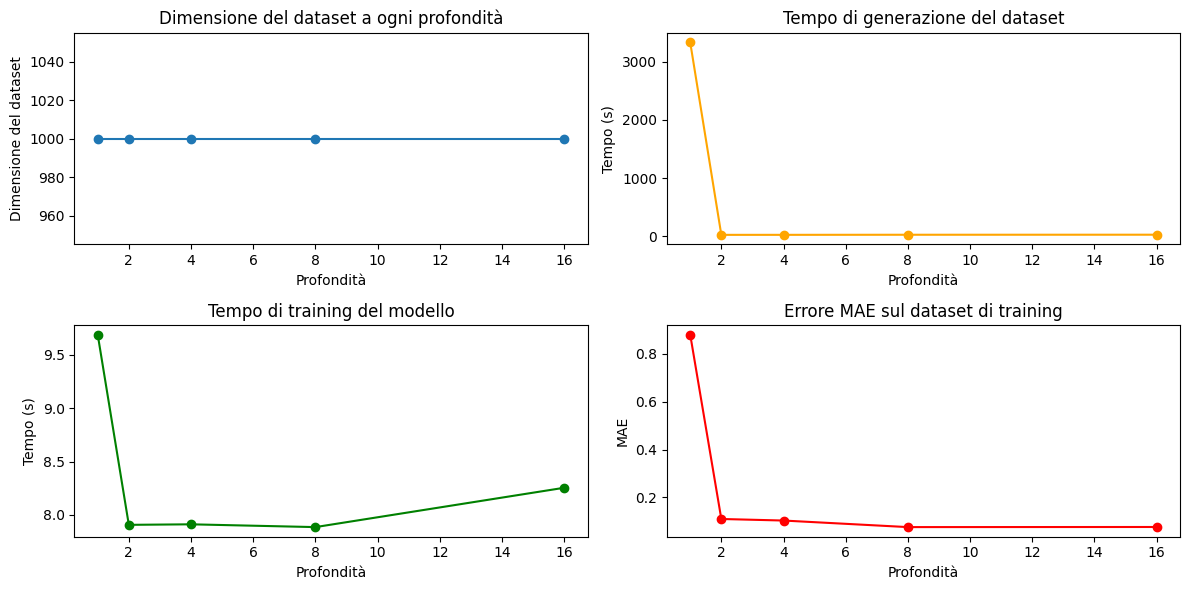

In [ ]:
models_nuovo_adattato= get_trained_models(num_boards=1000, initial_L=1, max_L=16, depth_minmax=4)

In [6]:
def iterative_bootstrap(board_states, initial_depth=1, max_depth=8, depth_minmax=4, save_initial_dataset=True, dataset="initial_dataset.pkl"):
    """Iterative: trains RL regressors to simulate deeper explorations, with dataset growth."""
    depth = initial_depth
    models = []
    dataset_sizes = []
    training_times = []
    mae_values = []
    generation_times = []

    rl_regressor = None
    current_board_states = board_states

    initial_dataset_generated = False

    while depth <= max_depth:
        print(f"Generazione dataset per profondità {depth}")

        if rl_regressor is None:
            if save_initial_dataset and not initial_dataset_generated:
                print("Generazione del dataset iniziale...")
                X, y, gen_time = generate_dataset(current_board_states, lambda b, d: abMinMaxL(b, d), depth_minmax)
                initial_dataset_generated = True

                print(f"Salvataggio del dataset iniziale in '{dataset}'...")
                with open(dataset, "wb") as f:
                    pickle.dump((X, y), f)

            else:
                print(f"Caricamento del dataset iniziale da '{dataset}'...")
                with open(dataset, "rb") as f:
                    X, y = pickle.load(f)
                gen_time = 0

        else:
            print(f"Simulazione dataset con il regressore RL per profondità {depth}")
            start_time = time.time()
            simulated_dataset = simulate_dataset_with_regressor(rl_regressor, current_board_states)
            X, y = zip(*simulated_dataset)
            X = np.array(X)
            y = np.array(y)
            gen_time = time.time() - start_time

        dataset_sizes.append(len(X))
        generation_times.append(gen_time)

        print(f"Allenamento regressore RL per profondità {depth}")
        rl_regressor = RegressorRL(input_dim=X[0].shape[0])
        start_time = time.time()
        history = rl_regressor.train(X, y)
        end_time = time.time()
        training_times.append(end_time - start_time)

        mae = history.history['mae'][-1]
        mae_values.append(mae)

        print(f"Profondità {depth} completata: MAE={mae:.4f}, Tempo di training={end_time - start_time:.2f}s")
        models.append(rl_regressor)

        new_size = int(len(current_board_states) * 1.25)
        print(f"Aumento del dataset da {len(current_board_states)} a {new_size} board states")
        current_board_states = generate_random_board_states(new_size)

        depth *= 2

    plot_statistics(dataset_sizes, training_times, generation_times, mae_values, initial_depth, max_depth)

    return models

Generazione degli stati iniziali della scacchiera...
Inizio bootstrap iterativo...
Generazione dataset per profondità 1
Generazione del dataset iniziale...


Generating dataset: 100%|██████████| 1000/1000 [54:25<00:00,  3.27s/it] 

Dataset generato in 3265.72 secondi.
Salvataggio del dataset iniziale in 'initial_dataset.pkl'...
Allenamento regressore RL per profondità 1
Epoch 1/150
 1/32 [..............................] - ETA: 4s - loss: 48.1983 - mae: 6.8291

32/32 [==============================] - 0s 3ms/step - loss: 6.4104 - mae: 1.9240
Epoch 2/150
32/32 [==============================] - 0s 3ms/step - loss: 2.3659 - mae: 1.2099
Epoch 3/150
32/32 [==============================] - 0s 3ms/step - loss: 2.3306 - mae: 1.2003
Epoch 4/150
32/32 [==============================] - 0s 3ms/step - loss: 2.1119 - mae: 1.1333
Epoch 5/150
32/32 [==============================] - 0s 2ms/step - loss: 1.9963 - mae: 1.1023
Epoch 6/150
32/32 [==============================] - 0s 2ms/step - loss: 1.9705 - mae: 1.0950
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 1.8521 - mae: 1.0541
Epoch 8/150
32/32 [==============================] - 0s 2ms/step - loss: 1.8094 - mae: 1.0492
Epoch 9/150
32/32 [==============================] - 0s 2ms/step - loss: 1.8553 - mae: 1.0666
Epoch 10/150
32/32 [==============================] - 0s 2ms/step - loss: 1.8025 - mae: 1.0507
Epoch 11/150
32/32 [==============================] - 0s 2ms/step - los

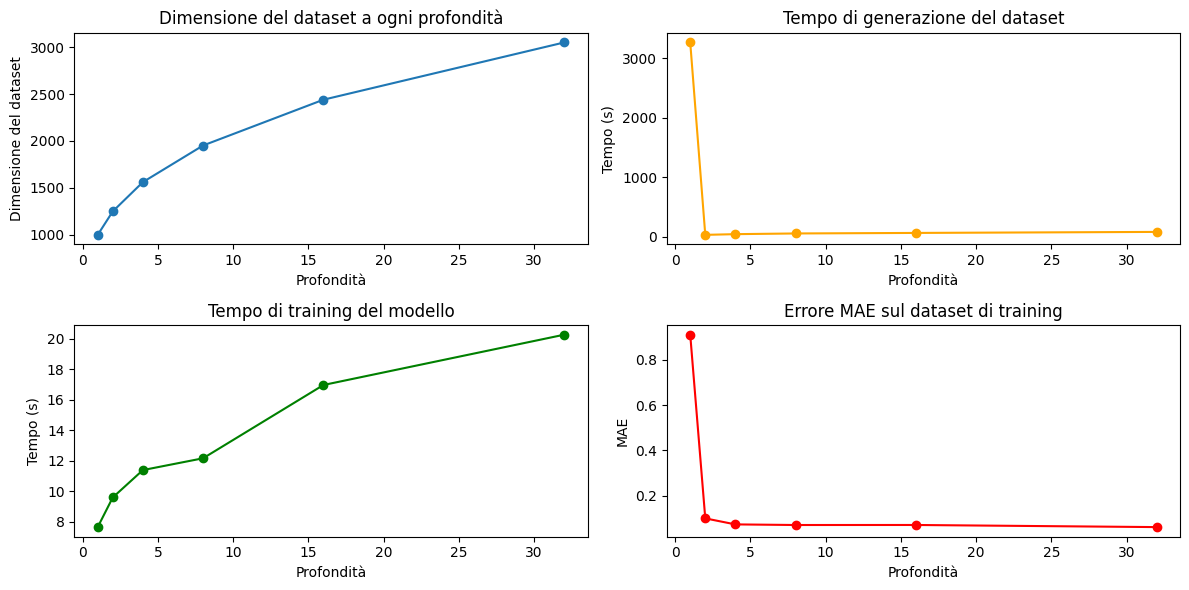

In [ ]:
models_nuovo_adattato_incr = get_trained_models(num_boards=1000, initial_L=1, max_L=32, depth_minmax=4)

In [ ]:
def play_with_rl1_minmax(board, rl1_regressor, depth=4):
    """
    Args:
        board (chess.Board): Lo stato attuale della scacchiera.
        rl1_regressor (RegressorRL): Il modello RL1 addestrato per valutare gli stati.
        depth (int): Profondità del MinMax. Di default è 4.

    Returns:
        chess.Move: La mossa scelta dal modello RL1.
    """
    def abRL1MinMax(board, depth, is_maximizing, rl1_regressor):
        """MinMax con RL1 come funzione di valutazione."""
        if depth == 0 or board.is_game_over():
            features = extract_features(board)
            return rl1_regressor.predict(features.reshape(1, -1))[0]

        if is_maximizing:
            max_eval = -np.inf
            for move in board.legal_moves:
                board.push(move)
                eval = abRL1MinMax(board, depth - 1, False, rl1_regressor)
                max_eval = max(max_eval, eval)
                board.pop()
            return max_eval
        else:
            min_eval = np.inf
            for move in board.legal_moves:
                board.push(move)
                eval = abRL1MinMax(board, depth - 1, True, rl1_regressor)
                min_eval = min(min_eval, eval)
                board.pop()
            return min_eval

    best_move = None
    best_value = -np.inf if board.turn else np.inf
    for move in board.legal_moves:
        board.push(move)
        move_value = abRL1MinMax(board, depth - 1, not board.turn, rl1_regressor)
        board.pop()

        if board.turn:
            if move_value > best_value:
                best_value = move_value
                best_move = move
        else:
            if move_value < best_value:
                best_value = move_value
                best_move = move

    return best_move

MAX_MOVES = 100

res = []
for i in tqdm(range(100), desc="Games..."):
    board = chess.Board()

    while not board.is_game_over() and board.halfmove_clock < MAX_MOVES:

        if board.turn:
            move = play_with_rl1_minmax(board, models_nuovo_adattato_incr[-1], depth=2)
        else:
            move = np.random.choice(list(board.legal_moves))
        board.push(move)

    if board.is_game_over():
        result = board.result()
    elif board.halfmove_clock >= MAX_MOVES:
        result = "1/2-1/2"

    res.append(result)

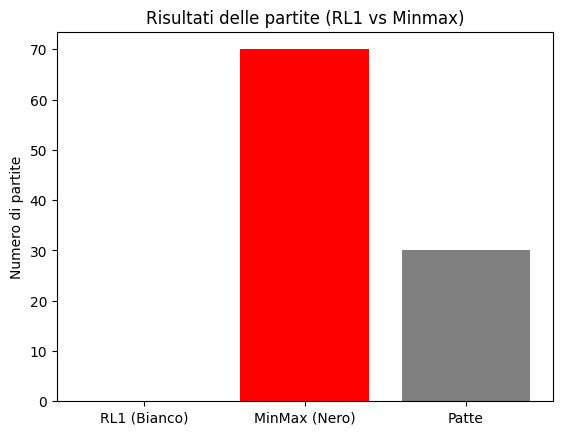

In [4]:
wins_rl1 = res.count("1-0")
wins_mm = res.count("0-1")
draws = res.count("1/2-1/2")

labels = ['RL1 (Bianco)', 'MinMax (Nero)', 'Patte']
counts = [wins_rl1, wins_mm, draws]

plt.bar(labels, counts, color=['blue', 'red', 'gray'])
plt.title("Risultati delle partite (RL1 vs Minmax)")
plt.ylabel("Numero di partite")
plt.show()

In [ ]:
df = pd.DataFrame(X)
df['label'] = y

print(df.head())
print(df.describe())

   0  1  2  3  4  5  6   7   8  9  10  11  12  13  14  label
0  0  1  1  1  1  0 -1  16  16  0   2   0  21   0   0    7.4
1  0  1  1  1  1  0 -1  16  16  0   1   0  21   0   0    8.4
2  0  1  0  1  1  1 -1  16  16  0   4   2  32   0   0    8.1
3  0  1  1  1  1  2 -1  16  16  0   2   0  21   0   0    7.3
4  1  1  0  1  0  1 -1  16  16  0   1   4  26   0   0    7.4
                 0            1            2            3            4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.472000     0.797000     0.794000     0.821000     0.815000   
std       0.499465     0.402434     0.404633     0.383544     0.388492   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     1.000000     1.000000     1.000000   
50%       0.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.0000

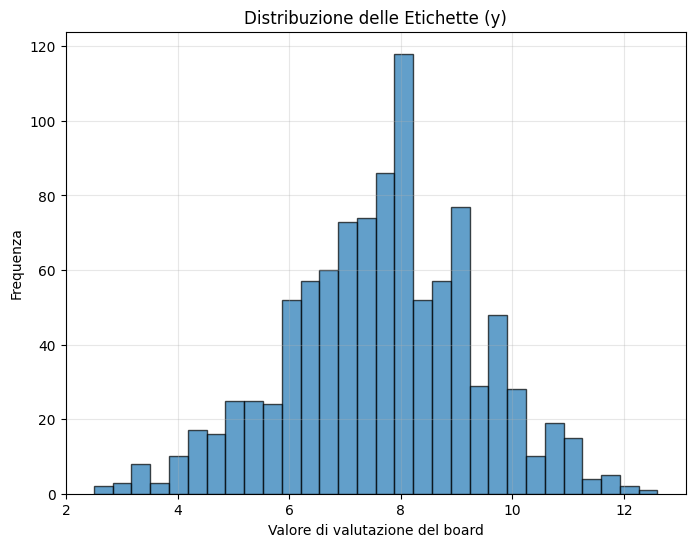

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribuzione delle Etichette (y)")
plt.xlabel("Valore di valutazione del board")
plt.ylabel("Frequenza")
plt.grid(alpha=0.3)
plt.show()

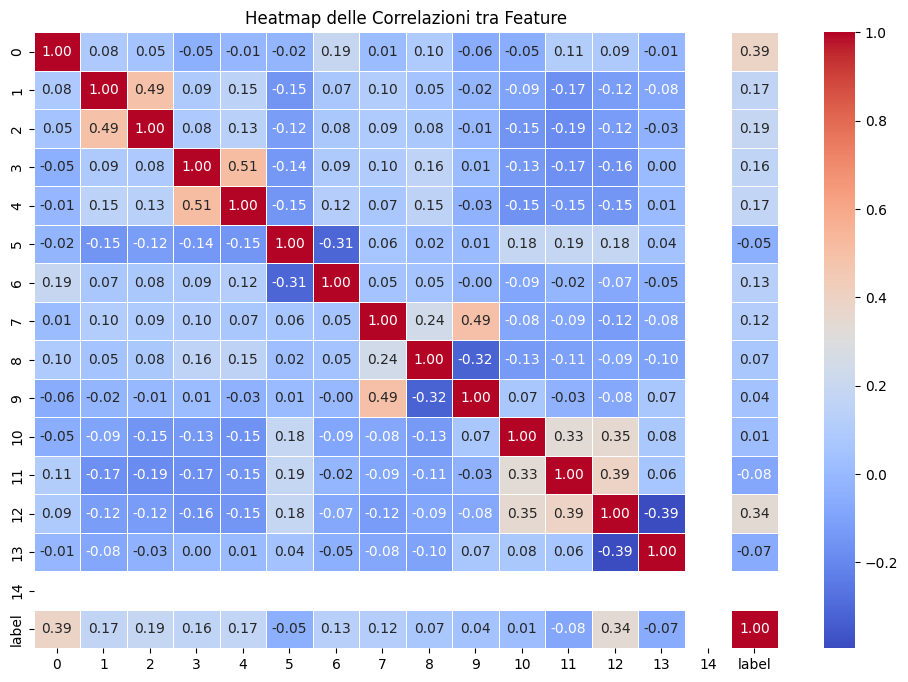

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap delle Correlazioni tra Feature")
plt.show()

In [ ]:
feature_names = {
    0: 'turn',
    1: 'castling_white_kingside',
    2: 'castling_white_queenside',
    3: 'castling_black_kingside',
    4: 'castling_black_queenside',
    5: 'halfmove_clock',
    6: 'en_passant',
    7: 'white_pieces',
    8: 'black_pieces',
    9: 'material_score',
    10: 'white_center_control',
    11: 'black_center_control',
    12: 'legal_moves_count',
    13: 'is_check',
    14: 'is_checkmate'
}

df = pd.DataFrame(X)
df.rename(columns=feature_names, inplace=True)

df['label'] = y

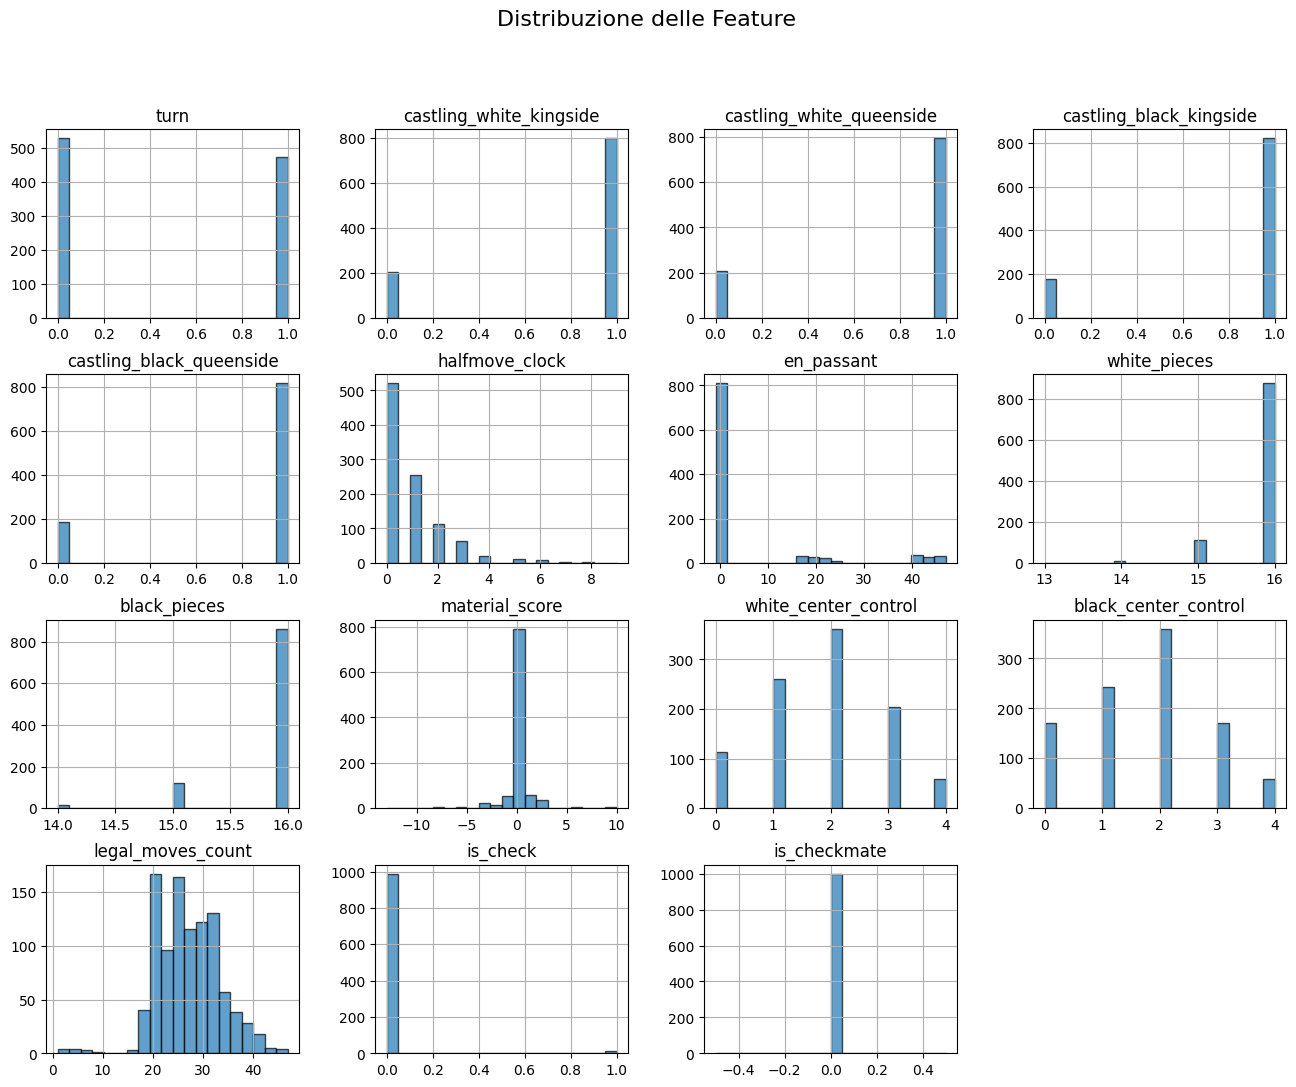

In [ ]:
df_features = df.drop(columns=['label'])
df_features.hist(figsize=(16, 12), bins=20, edgecolor='k', alpha=0.7)
plt.suptitle("Distribuzione delle Feature", fontsize=16)
plt.show()

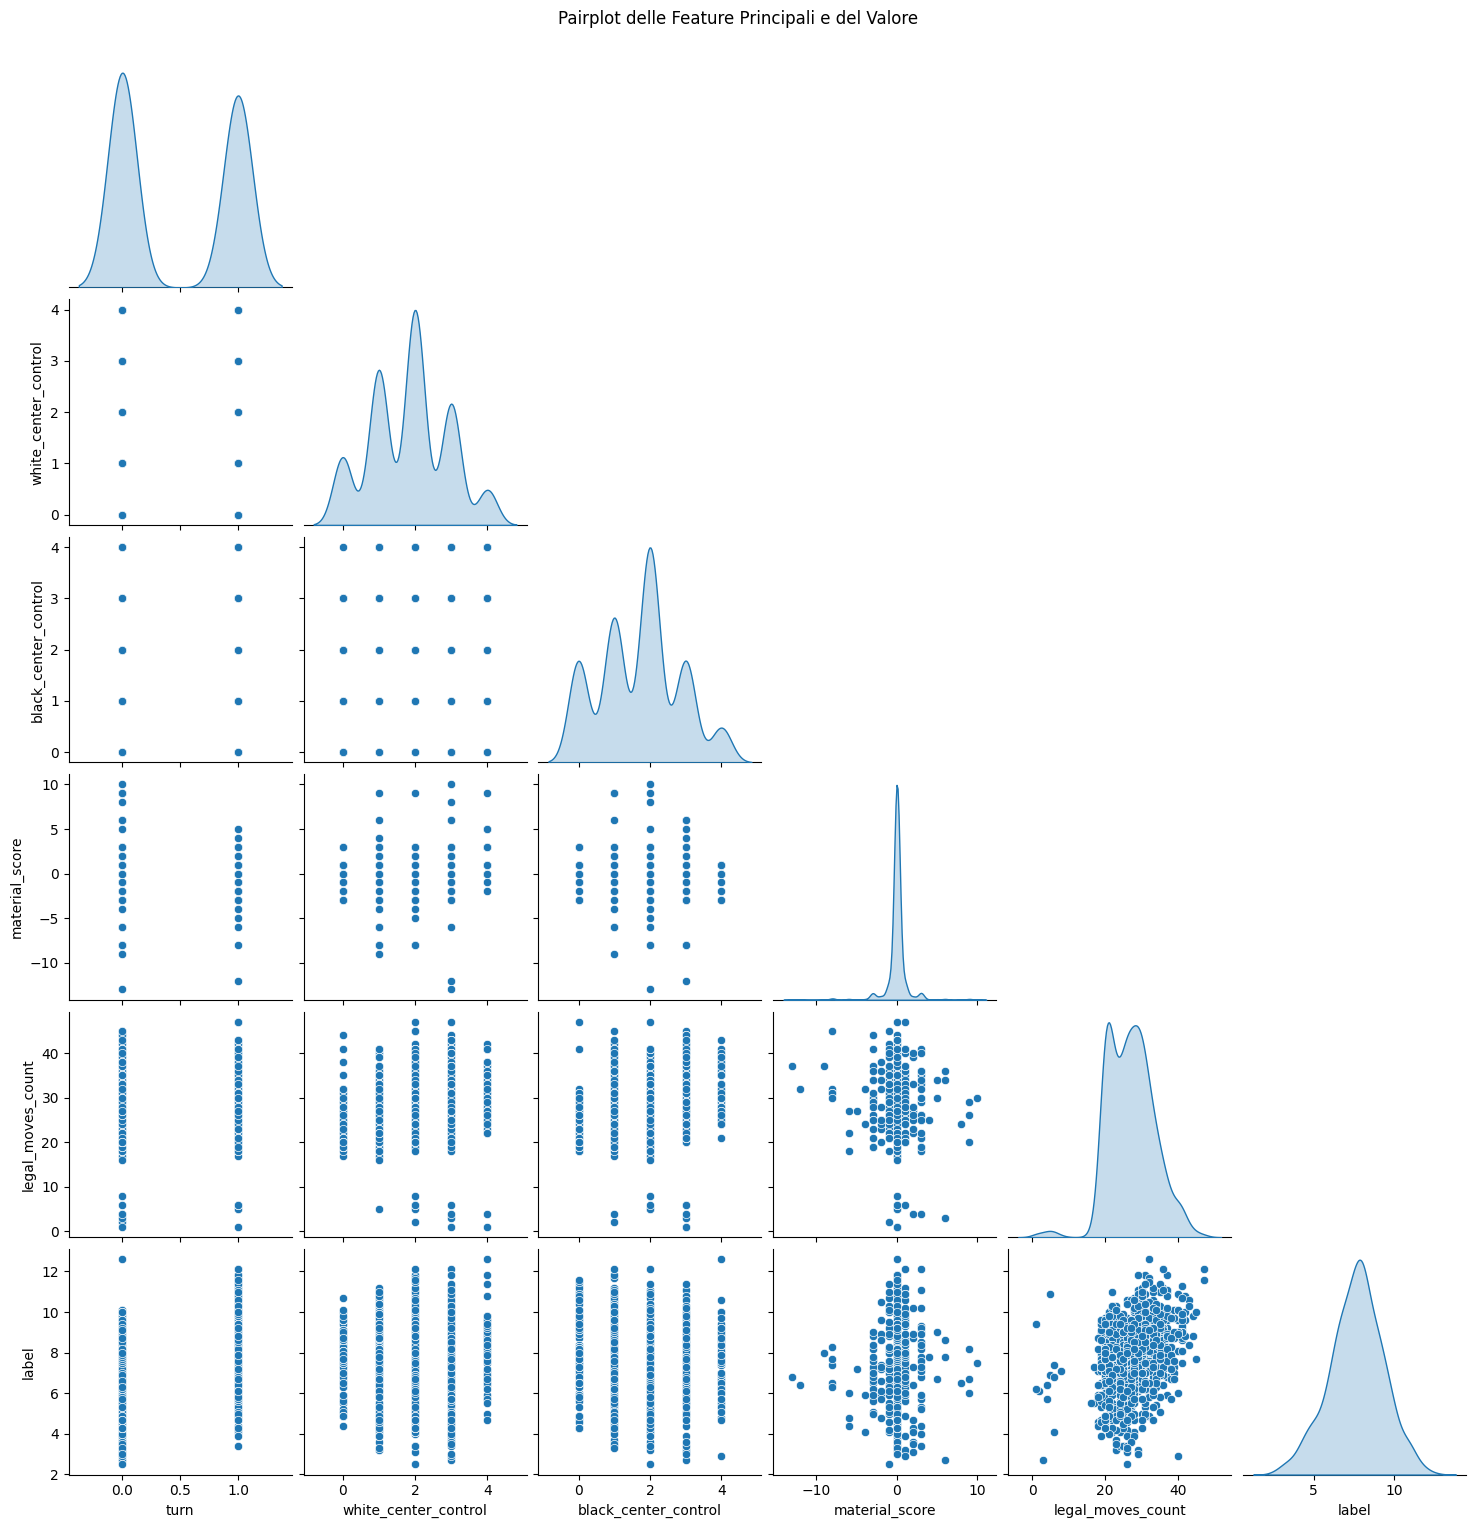

In [ ]:
sns.pairplot(df[important_features + ['label']], diag_kind='kde', corner=True)
plt.suptitle("Pairplot delle Feature Principali e del Valore", y=1.02)
plt.show()

<ipython-input-23-8bffb8b378f6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='turn', data=df, palette='coolwarm')


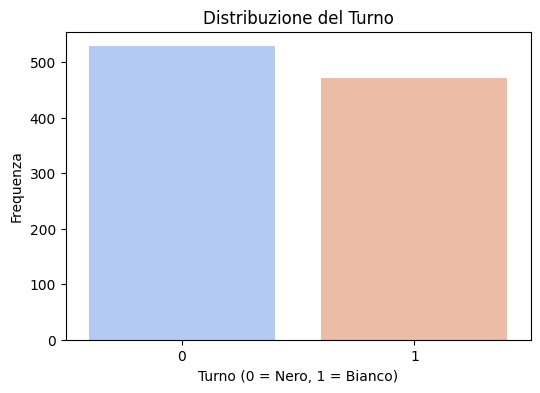

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='turn', data=df, palette='coolwarm')
plt.title("Distribuzione del Turno")
plt.xlabel("Turno (0 = Nero, 1 = Bianco)")
plt.ylabel("Frequenza")
plt.show()

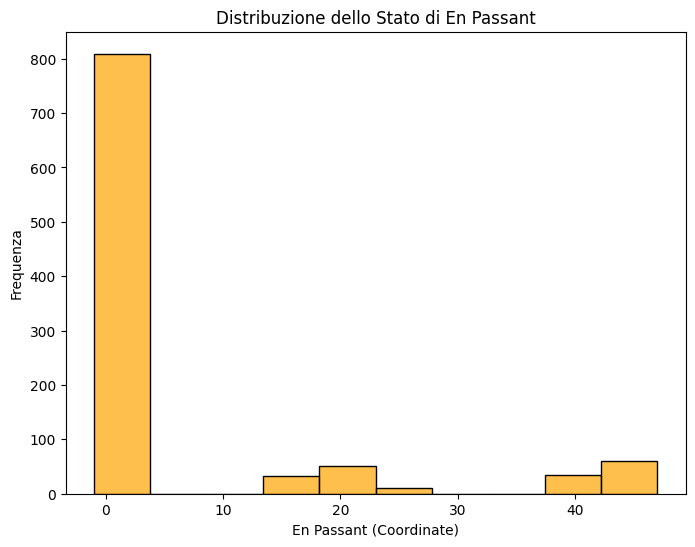

en_passant
-1     809
 19     17
 43     14
 42     14
 44     14
 18     13
 21     13
 45     11
 23     11
 17     11
 46     11
 41     11
 22     11
 47     11
 20     10
 40     10
 16      9
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['en_passant'], bins=10, kde=False, color='orange', alpha=0.7)
plt.title("Distribuzione dello Stato di En Passant")
plt.xlabel("En Passant (Coordinate)")
plt.ylabel("Frequenza")
plt.show()
print(df['en_passant'].value_counts())

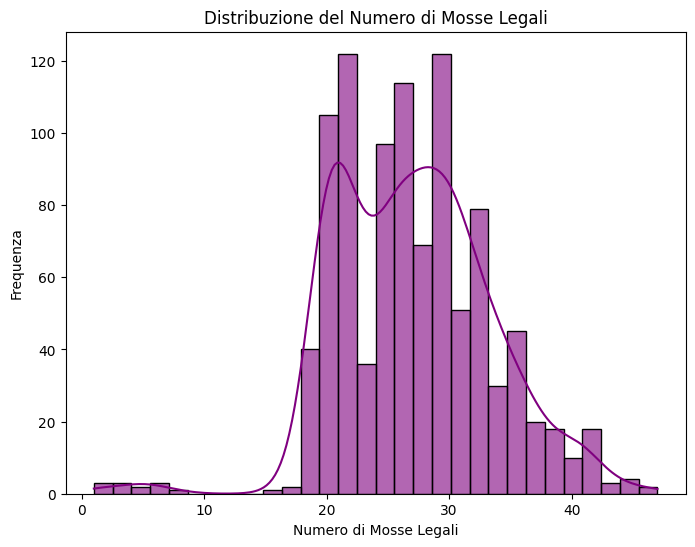

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['legal_moves_count'], bins=30, kde=True, color='purple', alpha=0.6)
plt.title("Distribuzione del Numero di Mosse Legali")
plt.xlabel("Numero di Mosse Legali")
plt.ylabel("Frequenza")
plt.show()

<ipython-input-33-1b04b1467b8d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='is_check', palette='Blues', alpha=0.7)


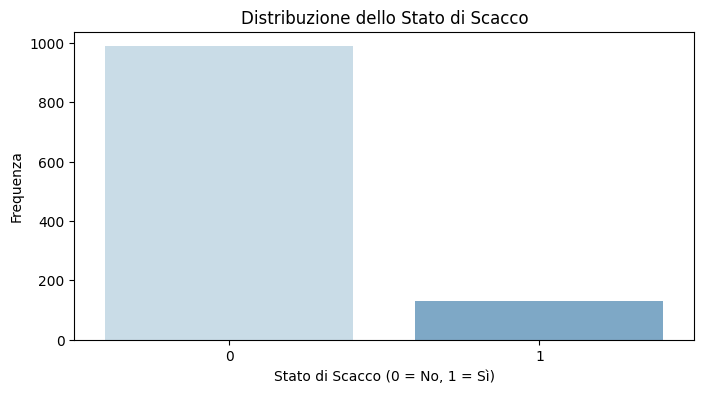

<ipython-input-33-1b04b1467b8d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='is_checkmate', palette='Reds', alpha=0.7)


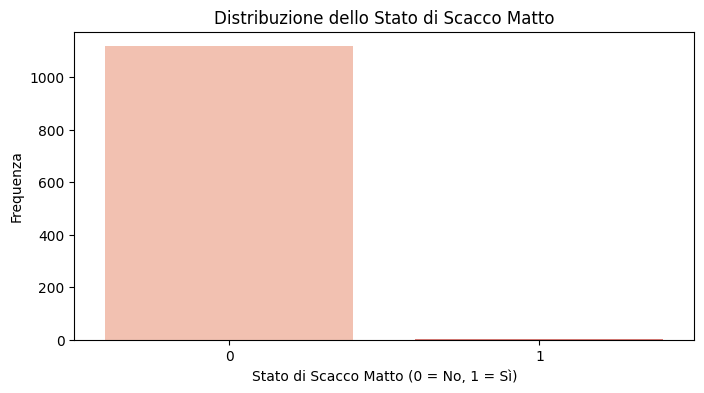

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='is_check', palette='Blues', alpha=0.7)
plt.title("Distribuzione dello Stato di Scacco")
plt.xlabel("Stato di Scacco (0 = No, 1 = Sì)")
plt.ylabel("Frequenza")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='is_checkmate', palette='Reds', alpha=0.7)
plt.title("Distribuzione dello Stato di Scacco Matto")
plt.xlabel("Stato di Scacco Matto (0 = No, 1 = Sì)")
plt.ylabel("Frequenza")
plt.show()